In [24]:
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
from rasterio.mask import mask

In [ ]:
# Load country boundaries (Canada)
gdf = gpd.read_file('data/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp')
canada_gdf = gdf[gdf['NAME'] == 'Canada']

In [56]:
tif_file = 'wc2.1_30s_tavg_06.tif'
with rasterio.open(tif_file) as src:
    raster_data = src.read()  # read the first band
    print(raster_data.max(), raster_data.min())
    affine = src.transform
    clipped_raster, clipped_transform = mask(src, canada_gdf.geometry, crop=True)

/home/alexis/Documents/projets/species_dist/.venv/lib/python3.12/site-packages/matplotlib/image.py:499: RuntimeWarning: overflow encountered in cast
  A_scaled /= ((a_max - a_min) / frac)
/home/alexis/Documents/projets/species_dist/.venv/lib/python3.12/site-packages/matplotlib/image.py:500: RuntimeWarning: overflow encountered in cast
  vrange /= ((a_max - a_min) / frac)
/home/alexis/Documents/projets/species_dist/.venv/lib/python3.12/site-packages/matplotlib/image.py:513: RuntimeWarning: overflow encountered in cast
  A_resampled *= ((a_max - a_min) / frac)
/home/alexis/Documents/projets/species_dist/.venv/lib/python3.12/site-packages/matplotlib/image.py:513: RuntimeWarning: invalid value encountered in multiply
  A_resampled *= ((a_max - a_min) / frac)
/home/alexis/Documents/projets/species_dist/.venv/lib/python3.12/site-packages/matplotlib/image.py:514: RuntimeWarning: overflow encountered in cast
  vrange *= ((a_max - a_min) / frac)
/home/alexis/Documents/projets/species_dist/.venv

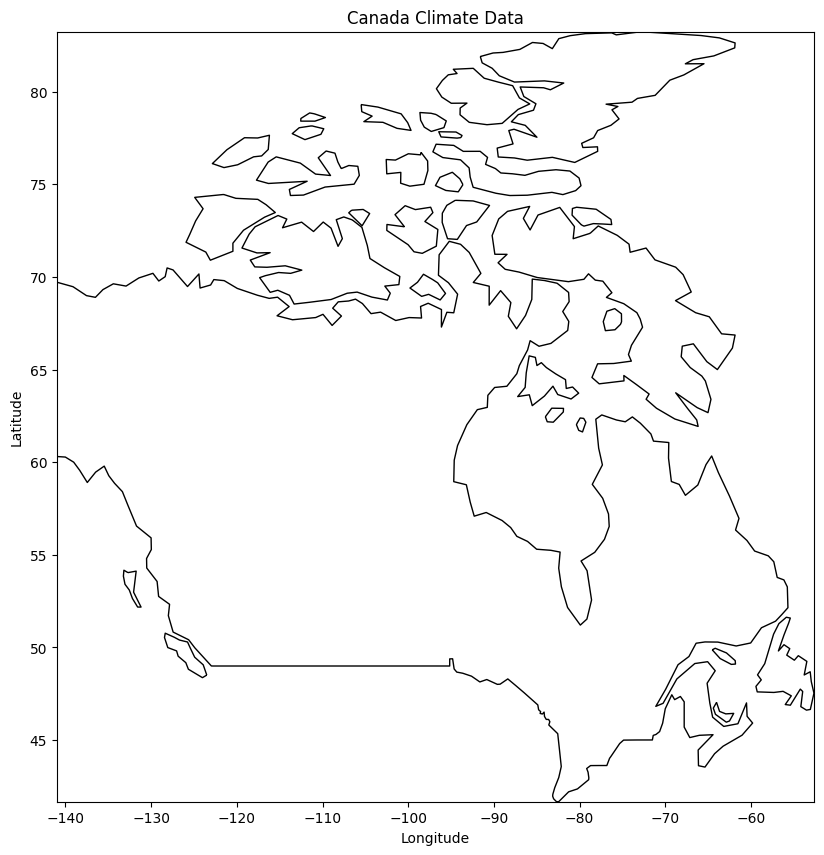

In [35]:
# Plot the clipped raster data
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(clipped_raster[0], cmap='viridis', extent=(clipped_transform.c, clipped_transform.c + clipped_transform.a * clipped_raster.shape[2], clipped_transform.f + clipped_transform.e * clipped_raster.shape[1], clipped_transform.f))
ax.set_title('Canada Climate Data')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
canada_gdf.boundary.plot(ax=ax, edgecolor='black', linewidth=1)

plt.show()

In [57]:
clipped_raster[0]

array([[-3.4e+38, -3.4e+38, -3.4e+38, ..., -3.4e+38, -3.4e+38, -3.4e+38],
       [-3.4e+38, -3.4e+38, -3.4e+38, ..., -3.4e+38, -3.4e+38, -3.4e+38],
       [-3.4e+38, -3.4e+38, -3.4e+38, ..., -3.4e+38, -3.4e+38, -3.4e+38],
       ...,
       [-3.4e+38, -3.4e+38, -3.4e+38, ..., -3.4e+38, -3.4e+38, -3.4e+38],
       [-3.4e+38, -3.4e+38, -3.4e+38, ..., -3.4e+38, -3.4e+38, -3.4e+38],
       [-3.4e+38, -3.4e+38, -3.4e+38, ..., -3.4e+38, -3.4e+38, -3.4e+38]],
      dtype=float32)

In [58]:
clipped_raster.mean()

/home/alexis/Documents/projets/species_dist/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:136: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


np.float32(-inf)